1. Libraries

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

warnings.filterwarnings("ignore")

2. Datasets and First View

In [16]:
# Los Angeles Dataset
la= pd.read_csv("Crime_Data_from_2020_to_Present.csv")


print(la.head())


                 DATE OCC  TIME OCC    AREA NAME  Vict Age Vict Sex  \
0  05/10/2020 12:00:00 AM      2200      Central        30        F   
1  12/02/2020 12:00:00 AM      2245  77th Street        21        M   
2  05/01/2020 12:00:00 AM      2330  77th Street        28        F   
3  01/18/2020 12:00:00 AM       940      Central        42        M   
4  11/15/2020 12:00:00 AM       310      Rampart        36        M   

  Vict Descent                                   Premis Desc  \
0            W  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
1            H                                        STREET   
2            B                        SINGLE FAMILY DWELLING   
3            A  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
4            W                          RESTAURANT/FAST FOOD   

                                      Weapon Desc   Status Desc  \
0  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)  Adult Arrest   
1                                   VERBAL THREAT   In

3. Preprocessing Dataset

In [17]:

def preprocess_la(df):
    df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
    df = df[df['DATE OCC'].notnull()]
    df['Year'] = df['DATE OCC'].dt.year
    df['Month'] = df['DATE OCC'].dt.month
    df['Day'] = df['DATE OCC'].dt.day
    df['Hour'] = df['TIME OCC'] // 100 if 'TIME OCC' in df.columns else 0
    df['Weekday'] = df['DATE OCC'].dt.weekday
    df = df[df['Crm Cd Desc'].notnull()]
    return df

4. Daily Summary Construction

In [18]:
def build_daily_summary(df, area_col, date_col, crime_col, victim_cols=[], premise_col=None):
    df['day'] = df[date_col].dt.date
    grouped = df.groupby([area_col, 'day'])

    daily_features = []

    for (area, day), group in grouped:
        summary = {
            area_col: area,
            'DAY': day,
            'Crime_Count': len(group),
            'Crime_Mode': group[crime_col].mode()[0] if not group[crime_col].mode().empty else "UNKNOWN"
        }

        if 'Vict Age' in group.columns:
            summary['Vict_Age_Mean'] = group['Vict Age'].mean() if not group['Vict Age'].isnull().all() else 0

        for col in victim_cols:
            if col in group.columns:
                counts = group[col].value_counts(normalize=True)
                for value, ratio in counts.items():
                    summary[f"{col}_{value}"] = ratio

        if premise_col and premise_col in group.columns:
            premise_counts = group[premise_col].value_counts(normalize=True)
            for value, ratio in premise_counts.items():
                summary[f"{premise_col}_{value}"] = ratio

        daily_features.append(summary)

    return pd.DataFrame(daily_features)

6. Time Series and Encoding

In [19]:
def build_time_series(data, area_col, day_col, label_col, window_size=5):
    data = data.sort_values(by=[area_col, day_col])
    data.reset_index(drop=True, inplace=True)
    features, labels = [], []

    grouped = data.groupby(area_col)

    for _, group in grouped:
        group = group.sort_values(by=day_col)
        group = group.reset_index(drop=True)

        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            label_day = group.iloc[i+window_size]

            if pd.isnull(label_day[label_col]):
                continue

            window_features = window.drop(columns=[area_col, day_col, label_col], errors='ignore')
            features.append(window_features.to_numpy().flatten())
            labels.append(label_day[label_col])

    return np.array(features), np.array(labels)

In [ ]:
#Reference to take advises (Dataset analysis has been made)
#https://doi.org/10.1109/TSMCC.2011.2161285
def filter_rare_labels(df, label_col='Crime_Mode', min_count=50, max_count=500):
    value_counts = df[label_col].value_counts()
    valid_classes = value_counts[(value_counts >= min_count) & (value_counts <= max_count)].index
    filtered_df = df[df[label_col].isin(valid_classes)]
    return filtered_df




In [21]:
def preprocess_for_model(X, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X = np.nan_to_num(X)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y_encoded, le, scaler

7. Model Training and Hyperparameter Optimizations

Training and optimization of their parameters


7.1 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#Random Forest
def train_random_forest(X, y, n_estimators=100, max_depth=None, min_samples_split=2, cv_splits=5):
    # Training RF model
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        prec_scores.append(precision_score(y_val, y_pred, average='weighted'))
        rec_scores.append(recall_score(y_val, y_pred, average='weighted'))

    print("Random Forest Evaluation (5-Fold CV):")
    print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(acc_scores), np.std(acc_scores)))
    print("F1 Score: {:.4f} ± {:.4f}".format(np.mean(f1_scores), np.std(f1_scores)))
    print("Precision: {:.4f} ± {:.4f}".format(np.mean(prec_scores), np.std(prec_scores)))
    print("Recall: {:.4f} ± {:.4f}".format(np.mean(rec_scores), np.std(rec_scores)))

# Hyperparameter optimization of RF
def optimize_random_forest(X, y, cv_splits=5):
   
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }

    grid = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=cv_splits,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X, y)

    best_params = grid.best_params_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score: {:.4f}".format(grid.best_score_))

    # Save
    best_model = grid.best_estimator_
    joblib.dump(best_model, "rf_la_model.pkl")
    print("Model saved as: rf_la_model.pkl")

    # En iyi parametrelerle modeli tekrar detaylı değerlendir
    train_random_forest(
        X,
        y,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        cv_splits=cv_splits
    )

    return best_model




7.2 KNN

In [ ]:
# KNN
def train_knn(X,y, n_neighbors=5, cv_splits=5):
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)

    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        prec_scores.append(precision_score(y_val, y_pred, average='weighted'))
        rec_scores.append(recall_score(y_val, y_pred, average='weighted'))

    print("KNN Evaluation (5-Fold CV):")
    print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(acc_scores), np.std(acc_scores)))
    print("F1 Score: {:.4f} ± {:.4f}".format(np.mean(f1_scores), np.std(f1_scores)))
    print("Precision: {:.4f} ± {:.4f}".format(np.mean(prec_scores), np.std(prec_scores)))
    print("Recall: {:.4f} ± {:.4f}".format(np.mean(rec_scores), np.std(rec_scores)))

def optimize_knn(X, y, cv_splits=5):
   
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11]
    }

    grid = GridSearchCV(
        estimator=KNeighborsClassifier(),
        param_grid=param_grid,
        cv=cv_splits,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X, y)

    best_params = grid.best_params_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score: {:.4f}".format(grid.best_score_))

    # Save
    best_model = grid.best_estimator_
    joblib.dump(best_model, "knn_la_model.pkl")
    print("Model saved as: knn_la_model.pkl")

    # Detaylı değerlendirme için train_knn fonksiyonunu çağır
    train_knn(
        X,
        y,
        n_neighbors=best_params['n_neighbors'],
        cv_splits=cv_splits
    )

    return best_model

7.3. Naive Bayes

In [24]:
def train_naive_bayes(X, y, cv_splits=5):

    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    model = GaussianNB()

    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        prec_scores.append(precision_score(y_val, y_pred, average='weighted'))
        rec_scores.append(recall_score(y_val, y_pred, average='weighted'))


    print("Naive Bayes Evaluation (5-Fold CV):")
    print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(acc_scores), np.std(acc_scores)))
    print("F1 Score: {:.4f} ± {:.4f}".format(np.mean(f1_scores), np.std(f1_scores)))
    print("Precision: {:.4f} ± {:.4f}".format(np.mean(prec_scores), np.std(prec_scores)))
    print("Recall: {:.4f} ± {:.4f}".format(np.mean(rec_scores), np.std(rec_scores)))
    joblib.dump(model, "naive_bayes_la_model.pkl")
    print("Model saved as: naive_bayes_la_model.pkl")


    

7.4. XGBoost

In [ ]:
def train_xgboost(X, y, learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0, colsample_bytree=1.0, cv_splits=5):
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    )

    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        prec_scores.append(precision_score(y_val, y_pred, average='weighted'))
        rec_scores.append(recall_score(y_val, y_pred, average='weighted'))

    print("XGBoost Evaluation (5-Fold CV):")
    print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(acc_scores), np.std(acc_scores)))
    print("F1 Score: {:.4f} ± {:.4f}".format(np.mean(f1_scores), np.std(f1_scores)))
    print("Precision: {:.4f} ± {:.4f}".format(np.mean(prec_scores), np.std(prec_scores)))
    print("Recall: {:.4f} ± {:.4f}".format(np.mean(rec_scores), np.std(rec_scores)))


def optimize_xgboost(X,y, cv_splits=5):
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    grid = GridSearchCV(
        estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        param_grid=param_grid,
        cv=cv_splits,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X, y)

    best_params = grid.best_params_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score: {:.4f}".format(grid.best_score_))

    # Save
    best_model = grid.best_estimator_
    joblib.dump(best_model, "xgb_la_model.pkl")
    print("Model saved as: xgb_la_model.pkl")

    # Detaylı sonuçlar için eğitim fonksiyonu çağrısı
    train_xgboost(
        X,
        y,
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        cv_splits=cv_splits
    )

    return best_model


7.5. MLP (Multi-Layer Perceptron)

In [ ]:
def train_mlp(X, y, hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, cv_splits=5):
    
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )

    acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        prec_scores.append(precision_score(y_val, y_pred, average='weighted'))
        rec_scores.append(recall_score(y_val, y_pred, average='weighted'))

    print("MLP Evaluation (5-Fold CV):")
    print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(acc_scores), np.std(acc_scores)))
    print("F1 Score: {:.4f} ± {:.4f}".format(np.mean(f1_scores), np.std(f1_scores)))
    print("Precision: {:.4f} ± {:.4f}".format(np.mean(prec_scores), np.std(prec_scores)))
    print("Recall: {:.4f} ± {:.4f}".format(np.mean(rec_scores), np.std(rec_scores)))

def optimize_mlp(X,y,cv_splits=5):
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'max_iter': [200, 300]
    }

    grid = GridSearchCV(
        estimator=MLPClassifier(random_state=42),
        param_grid=param_grid,
        cv=cv_splits,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X, y)

    best_params = grid.best_params_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score: {:.4f}".format(grid.best_score_))

    # Save
    best_model = grid.best_estimator_
    joblib.dump(best_model, "mlp_la_model.pkl")
    print("Model saved as: mlp_la_model.pkl")

    # Detaylı değerlendirme için train fonksiyonu çağır
    train_mlp(
        X,
        y,
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation'],
        solver=best_params['solver'],
        max_iter=best_params['max_iter'],
        cv_splits=cv_splits
    )

    return best_model





================== Window Size: 3 ==================

Random Forest - Accuracy: 0.4250
KNN - Accuracy: 0.3500
Naive Bayes - Accuracy: 0.5000
XGBoost - Accuracy: 0.4500
MLP - Accuracy: 0.4500

================== Window Size: 5 ==================

Random Forest - Accuracy: 0.4242
KNN - Accuracy: 0.4848
Naive Bayes - Accuracy: 0.3939
XGBoost - Accuracy: 0.5152
MLP - Accuracy: 0.4545

================== Window Size: 7 ==================

Random Forest - Accuracy: 0.6538
KNN - Accuracy: 0.5000
Naive Bayes - Accuracy: 0.4615
XGBoost - Accuracy: 0.6538
MLP - Accuracy: 0.5769

================== Window Size: 10 ==================

Random Forest - Accuracy: 0.4706
KNN - Accuracy: 0.5294
Naive Bayes - Accuracy: 0.1765
XGBoost - Accuracy: 0.4118
MLP - Accuracy: 0.5882
En iyi Window Size: 7

==== Accuracy Summary ====
    Window Size          Model  Accuracy
13            7        XGBoost  0.653846
10            7  Random Forest  0.653846
19           10            MLP  0.588235
14            7  

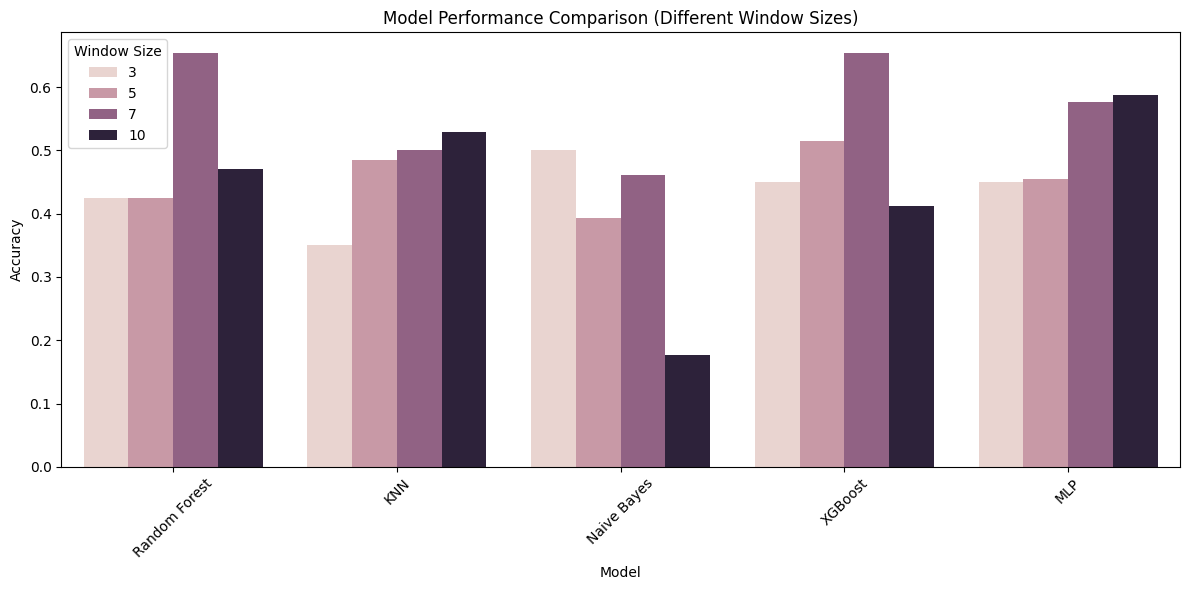

In [27]:
# Sample to analyze the accuracy
window_sizes = [3, 5, 7, 10]
results = []
la = preprocess_la(la)
summary_df = build_daily_summary(la, area_col='AREA NAME', date_col='DATE OCC', crime_col='Crm Cd Desc', victim_cols=['Vict Sex', 'Vict Descent'], premise_col='Premis Desc')


summary_df = filter_rare_labels(summary_df, label_col='Crime_Mode', min_count=50, max_count=80)


X, y = build_time_series(summary_df, area_col='AREA NAME', day_col='DAY', label_col='Crime_Mode')

df_features = pd.DataFrame(X)
nan_mask = df_features.isnull().any(axis=1)

if nan_mask.sum() > 0:
    
    X = df_features[~nan_mask].values
    y = y[~nan_mask.values]

results = []

for w_size in window_sizes:
    print(f"\n================== Window Size: {w_size} ==================\n")
    
    X, y = build_time_series(summary_df, area_col='AREA NAME', day_col='DAY', label_col='Crime_Mode', window_size=w_size)
    
    if len(X) == 0 or len(y) == 0:
        
        continue

    X_scaled, y_encoded, _, _ = preprocess_for_model(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Naive Bayes': GaussianNB(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42),
        'MLP': MLPClassifier(random_state=42, max_iter=300)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} - Accuracy: {acc:.4f}")
        results.append((w_size, name, acc))

# En iyi sonuçları özetle
df_results = pd.DataFrame(results, columns=["Window Size", "Model", "Accuracy"])
best_result = df_results.loc[df_results['Accuracy'].idxmax()]
print(f"En iyi Window Size: {best_result['Window Size']}")
print("\n==== Accuracy Summary ====")
print(df_results.sort_values(by="Accuracy", ascending=False))


plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x="Model", y="Accuracy", hue="Window Size")
plt.title("Model Performance Comparison (Different Window Sizes)")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Window Size")
plt.tight_layout()
plt.show()

In [14]:
X, y = build_time_series(summary_df, area_col='AREA NAME', day_col='DAY', label_col='Crime_Mode', window_size=best_result['Window Size'])
X_scaled, y_encoded, le, scaler = preprocess_for_model(X, y)

joblib.dump(scaler, "scaler_la.pkl")
joblib.dump(le, "label_encoder_la.pkl")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

best_model = optimize_random_forest(X_train, y_train)

# Final Test Evaluation
y_pred = best_model.predict(X_test)
print("\nFinal Test Evaluation Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# KNN
best_knn = optimize_knn(X_train, y_train)
y_pred_knn = best_knn.predict(X_test)
print("\n[KNN Test Evaluation]")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# 3. Naive Bayes (optimizasyon yok)
train_naive_bayes(X_train, y_train)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("\n[Naive Bayes Test Evaluation]")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# 4. XGBoost
best_xgb = optimize_xgboost(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
print("\n[XGBoost Test Evaluation]")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# 5. MLP
best_mlp = optimize_mlp(X_train, y_train)
y_pred_mlp = best_mlp.predict(X_test)
print("\n[MLP Test Evaluation]")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy Score: 0.6381
Model saved as: rf_la_model.pkl
Random Forest Evaluation (5-Fold CV):
Accuracy: 0.5500 ± 0.0777
F1 Score: 0.5092 ± 0.1124
Precision: 0.5393 ± 0.1676
Recall: 0.5500 ± 0.0777

Final Test Evaluation Random Forest:
Accuracy: 0.6538461538461539
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.60      0.38      0.46         8
           2       0.40      0.67      0.50         3
           3       1.00      0.83      0.91        12

    accuracy                           0.65        26
   macro avg       0.58      0.64      0.58        26
weighted avg       0.73      0.65      0.67        26

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_neighbors': 5}
Best Accuracy Score: 0.5200
Model sa